In [74]:
# imports
import time
import sklearn
import pandas as pd
import numpy
import swifter
import cv2
import matplotlib.pyplot as plt 
import multiprocess as mp



from PIL import Image, ImageOps, ImageEnhance
from skimage.feature import hog
from sklearn import decomposition    


# directorios
train_dir = '../data/processed/train'
test_dir = '../data/processed/test'

train_nmf_dir = '../data/processed/nmf/train'
test_nmf_dir = '../data/processed/nmf/test'

train_csv_path = '../data/processed/train_split.txt'
test_csv_path = '../data/processed/test_split.txt'

train_hog_nmf_csv_path = '../data/processed/nmf/train_split.txt'
test_hog_nmf_csv_path = '../data/processed/nmf/test_split.txt'

In [58]:
train_df = pd.read_csv(train_csv_path, delimiter = ',', header='infer')
test_df = pd.read_csv(test_csv_path, delimiter = ',', header='infer')

In [59]:
train_df.head(10)

,Unnamed: 0,patient_id,image_id,disease,method,ancho,alto
0,0,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia,cohen,1692,1474
1,1,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia,cohen,1800,1546
2,2,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia,cohen,1800,1546
3,3,7,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia,cohen,1772,1800
4,4,7,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia,cohen,1708,1710
5,5,9,SARS-10.1148rg.242035193-g04mr34g07a-Fig7a-day...,pneumonia,cohen,1800,1508
6,6,9,SARS-10.1148rg.242035193-g04mr34g07b-Fig7b-day...,pneumonia,cohen,1800,1522
7,7,10,SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day...,pneumonia,cohen,1750,1800
8,8,10,SARS-10.1148rg.242035193-g04mr34g09b-Fig9b-day...,pneumonia,cohen,1800,1779
9,9,10,SARS-10.1148rg.242035193-g04mr34g09c-Fig9c-day...,pneumonia,cohen,1787,1800


Tomo dos imágenes y comparo la imágen _"cruda"_ y la imágen luego de aplicar NMF

SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg


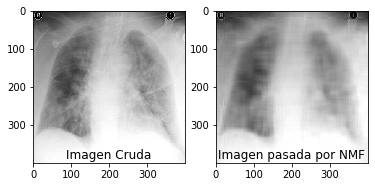

In [60]:
# https://stackoverflow.com/questions/44993322/non-negative-matrix-factorisation-in-python-on-individual-images
n_components = 20

train_img = train_df['image_id']
print(train_img[0])
img = cv2.imread(f'{train_dir}/{train_img[0]}', 0)  

vmax = max(img.max(), -img.min())
fig, (ax, ax2) = plt.subplots(ncols=2)    


ax.imshow(img, cmap=plt.cm.gray, interpolation = 'nearest',vmin=-vmax,vmax=vmax)
ax.set_title('Imagen Cruda', y=-0.01)

n_components = 20

estimator = decomposition.NMF(n_components = n_components, init = 'random', tol=5e-3)    
W = estimator.fit_transform(img)
H = estimator.components_

new_img = numpy.dot(W,H)
ax2.imshow(new_img, cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)

ax2.set_title('Imagen pasada por NMF', y=-0.01)
plt.show()


Pruebo guardar un file de una imágen NMF, al ser la imágen resultante una multiplicación de dos matrices.

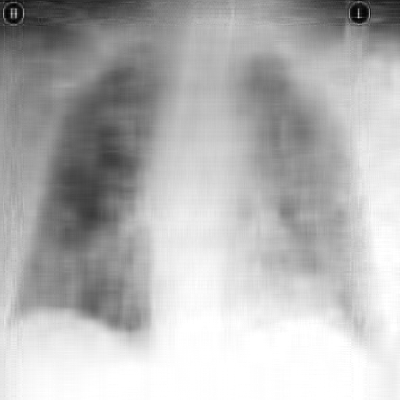

In [61]:
img = Image.open(f'{train_dir}/{train_img[0]}')

estimator = decomposition.NMF(n_components = n_components, init = 'random', tol=5e-3)    
W = estimator.fit_transform(img)
H = estimator.components_

new_img = numpy.dot(W, H)

result = Image.fromarray(new_img).convert('RGB')
result.save('test.tiff')
Image.open('test.tiff')

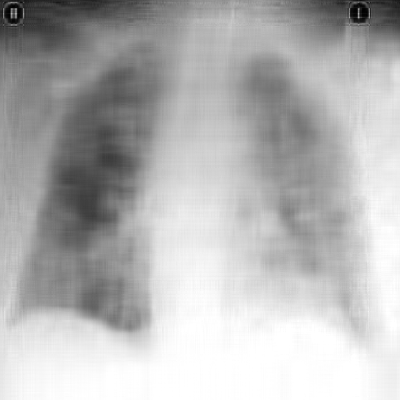

In [62]:
#  Verifico que funcione antes de correr el loop para todos
img = Image.open(f'{train_dir}/{train_img[0]}')
estimator = decomposition.NMF(n_components = n_components, init = 'random', tol=5e-3)    
W = estimator.fit_transform(img)
H = estimator.components_
img.close()
result_img = Image.fromarray(numpy.dot(W, H)).convert('RGB')
result_img
result_img


In [64]:
# parte train
start = time.time()
for index, name in enumerate(train_df['image_id']):
    img = Image.open(f'{train_dir}/{name}')
    estimator = decomposition.NMF(n_components = n_components, init = 'random', tol=5e-3)    
    W = estimator.fit_transform(img)
    H = estimator.components_
    img.close()
    result_img = Image.fromarray(numpy.dot(W, H)).convert('RGB')
    result_img.save(f'{train_nmf_dir}/{name}')
    result_img.close()
end = time.time()


In [65]:
print(round(end - start, 2), "segundos")

1321.76 segundos


In [66]:
# parte test
start = time.time()
for index, name in enumerate(test_df['image_id']):
    img = Image.open(f'{test_dir}/{name}')
    estimator = decomposition.NMF(n_components = n_components, init = 'random', tol=5e-3)    
    W = estimator.fit_transform(img)
    H = estimator.components_
    img.close()
    result_img = Image.fromarray(numpy.dot(W, H)).convert('RGB')
    result_img.save(f'{test_nmf_dir}/{name}')
    result_img.close()
end = time.time()

In [67]:
print(round(end - start, 2), "segundos")

146.38 segundos


In [68]:
def get_train_hogged_img(id):
    img = Image.open(f'{train_nmf_dir}/{id}')
    fd, hoggedImg = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    img.close()
    return fd, hoggedImg

def get_test_hogged_img(id):
    img = Image.open(f'{test_nmf_dir}/{id}')
    fd, hoggedImg = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    img.close()
    return fd, hoggedImg

In [72]:
start = time.time()
with mp.Pool() as p:
        result_test = p.map(get_test_hogged_img, test_df['image_id'])
end = time.time()

print("conjunto test: ", round(end-start, 2), " segundos")

result_test_df = pd.DataFrame(result_test, columns = ['features', 'hogged_img'])
result_test_df['features'] = result_test_df['features'].apply(lambda x: list(x))
result_test_df.to_csv(test_hog_nmf_csv_path)
result_test_df.head(10)

conjunto test:  104.36  segundos


,features,hogged_img
0,"[0.02705105981815912, 0.0, 0.0, 0.039409680643...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,"[0.2606366602440652, 0.3124750936954903, 0.124...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,"[0.45842221000070377, 0.13740779670673198, 0.2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,"[0.3849850164553064, 0.04914836231399041, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,"[0.4414475478504372, 0.19924520498368148, 0.05...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,"[0.11631075450277166, 0.20638893579784282, 0.2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,"[0.31774886959572407, 0.0034085860092542782, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,"[0.19894642529984977, 0.08813710110747786, 0.2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,"[0.06812645446495401, 0.006496334669921768, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,"[0.07546193180267767, 0.015287980365369252, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [73]:
start = time.time()
with mp.Pool() as p:
        result_train = p.map(get_train_hogged_img, train_df['image_id'])
end = time.time()
print("conjunto train: ", round(end-start, 2), " segundos")

result_train_df = pd.DataFrame(result_train, columns = ['features', 'hogged_img'])
del result_train_df['hogged_img']

result_train_df['features'] = result_train_df['features'].apply(lambda x: list(x))
print('termina el apply')

result_train_df.to_csv(train_hog_nmf_csv_path)
print('termina de pasar a csv')
result_train_df.head(10)

conjunto train:  2469.87  segundos
termina el apply


NameError: name 'train_hoged_nmf_csv_path' is not defined

In [75]:
result_train_df.to_csv(train_hog_nmf_csv_path)
print('termina de pasar a csv')
result_train_df.head(10)

termina de pasar a csv


,features
0,"[0.12418160035654287, 0.11057938516591702, 0.1..."
1,"[0.08821158414441169, 0.09161997739854053, 0.1..."
2,"[0.13655804837282656, 0.2375007180962649, 0.23..."
3,"[0.3222769727620392, 0.022967671078387587, 0.0..."
4,"[0.025275084346299537, 0.007594217648116013, 0..."
5,"[0.14194839250419267, 0.031740625959642034, 0...."
6,"[0.04421264967340874, 0.038071655496190904, 0...."
7,"[0.0236001674646301, 0.031850688950337075, 0.0..."
8,"[0.1675767277688176, 0.02661098442360383, 0.08..."
9,"[0.08491244512093893, 0.15591200635484065, 0.2..."
